# ICU admission w/ Iterative Imputer
Repeat all steps from other script

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from tabulate import tabulate
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.metrics import plot_precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics  import accuracy_score, auc, roc_curve, precision_recall_curve, f1_score, roc_auc_score, precision_score, recall_score, average_precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold

df = pd.read_excel("Downloads/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx")

In [3]:
conda install -c conda-forge shap

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install shap

In [3]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [4]:
# 2: Convert age percentile to ordinal
pcts = sorted(df.AGE_PERCENTIL.unique())
age_percentile_encoding = {k: i for i, k in enumerate(pcts)}
df.AGE_PERCENTIL = df.AGE_PERCENTIL.replace(age_percentile_encoding)

In [5]:
# GROUPING FEATURES
# DEMOGRAPHICS
demo_lst = [i for i in df.columns if "AGE_" in i]
demo_lst.append("GENDER")

# COMORBIDITIES
comorb_lst = [i for i in df.columns if "DISEASE" in i]
comorb_lst.extend(["HTN", "IMMUNOCOMPROMISED", "OTHER"])

# VITAL SIGNS
vitalSigns_lst = df.iloc[:,193:231].columns.tolist()

# LAB VALUES
lab_lst = df.iloc[:,13:193].columns.tolist()

# mean features
lab_median = [xi for xi in lab_lst if xi.endswith('MEDIAN')]
vital_median = [xi for xi in vitalSigns_lst if xi.endswith('MEDIAN')]

#DF WITH ONLY MEDIAN VALUES
df = df[demo_lst + comorb_lst + lab_median + vital_median + ['ICU'] + ['WINDOW'] + ['PATIENT_VISIT_IDENTIFIER']]

print(df.shape)

(1925, 57)


In [6]:
# 3: Remove zero / low variance columns 
df = df.loc[:, df.nunique() != 1] 
print(df.shape) #36 zero variance columns removed

(1925, 57)


In [7]:
colvar = df.var()
cols_to_remove = colvar[colvar < 0.01].index.tolist()
df = df.drop(columns = cols_to_remove)
print(df.shape) #28 low variance columns removed

(1925, 50)


AxesSubplot(0.125,0.125;0.62x0.755)


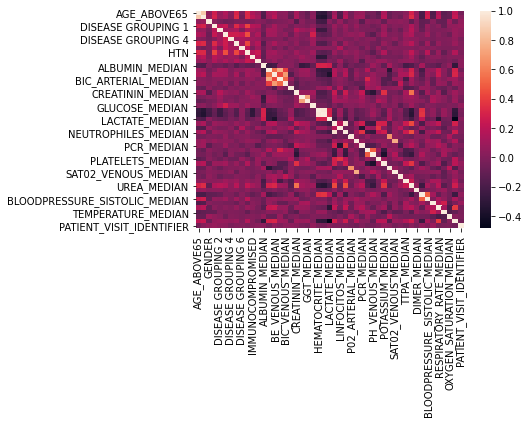

In [8]:
# 4: Remove high multicollinearity columns 
cor = df.corr(method = 'pearson')
print(sns.heatmap(cor))

In [9]:
corr_pairs = cor.unstack().sort_values(ascending = False).drop_duplicates()
high_corr = corr_pairs[abs(corr_pairs) > 0.8]

feature1_target = [] #Create a list of feature 1 names
for x in high_corr.index.to_list():
    feature1_target.append(x[0])
#print(feature1_target)

feature2_target = [] #Create a list of feature 2 names
for x in high_corr.index.to_list():
    feature2_target.append(x[1])
#print(feature2_target)

target_cor = abs(cor["ICU"]) 
#print(target_cor['TEMPERATURE_DIFF_REL'])
feature1_cor_icu = []
feature2_cor_icu = []

for feat in feature1_target:
    feature1_cor_icu.append(target_cor[feat])

for feat in feature2_target:
    feature2_cor_icu.append(target_cor[feat])

In [10]:
def compareList(l1, l2):
    return [i<j for i, j in zip(l1, l2)] #Is feature 1 correlation with target smaller than feature 2 correlation with target?

smaller_feat1 = compareList(feature1_cor_icu, feature2_cor_icu)
remove_smaller_feat1 = [x for x, y in zip(feature1_target, smaller_feat1) if y]
#print(remove_smaller_feat1)

smaller_feat2 = compareList(feature2_cor_icu, feature1_cor_icu)
remove_smaller_feat2 = [x for x, y in zip(feature2_target, smaller_feat2) if y]

#print(remove_smaller_feat2)
cols_multicollinear = remove_smaller_feat1 + remove_smaller_feat2

df = df.drop(columns = cols_multicollinear)
print(df.shape) #20 columns dropped

(1925, 47)


In [11]:
# 5: Add a minmax scaled column that is sum of missing value row wise. 
df['Missingness'] = df.isnull().sum(axis = 1)
scaler = MinMaxScaler()
df[['Missingness']] = scaler.fit_transform(df[['Missingness']])
#print(df.head())

In [12]:
#Make a dataframe of non-icu admitted patients's 0-2 h data
no_icu_data = df[(df.ICU == 0) & (df.WINDOW == 'ABOVE_12') ]
no_icu_id = no_icu_data['PATIENT_VISIT_IDENTIFIER'].to_list()
no_icu_df = df[(df.PATIENT_VISIT_IDENTIFIER.isin(no_icu_id) & (df.WINDOW == '0-2'))]
no_icu_df = no_icu_df.drop(columns = 'WINDOW')
#print(no_icu_df)

In [13]:
#Make dataframe of ICU admitted patients with lagged data. 
icu_df = df[np.logical_not(df.PATIENT_VISIT_IDENTIFIER.isin(no_icu_id))]
         
#FIRST DISCARD PATIENTS THAT ARE ICU ADMITTED IN 0-2H 
icu_df_grouped = icu_df.groupby('PATIENT_VISIT_IDENTIFIER')
icu_02_ids = []
for group_name, group in icu_df_grouped:
    group.ICU.to_list()
    if len(group['ICU'].unique()) ==1:
        icu_02_ids.append(group_name)   
print(icu_02_ids) #List of 32 id's of 0-2h admitted ICU

icu_df_no02 = icu_df[np.logical_not(icu_df.PATIENT_VISIT_IDENTIFIER.isin(icu_02_ids))] #Dataframe consisting if patients ICU admitted in either 2-4, 4-6, 6-12 or 12+

[1, 17, 27, 41, 47, 48, 54, 62, 85, 90, 104, 106, 109, 117, 144, 176, 202, 206, 226, 233, 239, 261, 270, 282, 286, 306, 315, 329, 359, 362, 366, 379]


In [14]:
#OF PATIENTS THAT ARE ADMITTED IN 2-4 HOUR TIMEFRAME, SELECT 0-2 H DATA. 
icu_24_ids = []
for group_name, group in icu_df_no02.groupby('PATIENT_VISIT_IDENTIFIER'):
    if group.ICU.to_list() == [0, 1, 1, 1, 1]:
        icu_24_ids.append(group_name)
print(icu_24_ids)

df_24_patient_data = icu_df_no02[(icu_df_no02.PATIENT_VISIT_IDENTIFIER.isin(icu_24_ids)) & (icu_df_no02['WINDOW'] == '0-2')]
#print(df_24_patient_data)

#OF PATIENTS THAT ARE ADMITTED IN 4-6 HOUR TIMEFRAME, SELECT 2-4 H DATA. 
icu_46_ids = []
for group_name, group in icu_df_no02.groupby('PATIENT_VISIT_IDENTIFIER'):
    if group.ICU.to_list() == [0, 0, 1, 1, 1]:
        icu_46_ids.append(group_name)
print(icu_46_ids)

df_46_patient_data = icu_df_no02[(icu_df_no02.PATIENT_VISIT_IDENTIFIER.isin(icu_46_ids)) & (icu_df_no02['WINDOW'] == '2-4')]
#print(df_46_patient_data)

#OF PATIENTS THAT ARE ADMITTED IN 6-12 HOUR TIMEFRAME, SELECT 4-6 H DATA. 
icu_612_ids = []
for group_name, group in icu_df_no02.groupby('PATIENT_VISIT_IDENTIFIER'):
    if group.ICU.to_list() == [0, 0, 0, 1, 1]:
        icu_612_ids.append(group_name)
print(icu_612_ids)

df_612_patient_data = icu_df_no02[(icu_df_no02.PATIENT_VISIT_IDENTIFIER.isin(icu_612_ids)) & (icu_df_no02['WINDOW'] == '4-6')]
#print(df_612_patient_data)

#OF PATIENTS THAT ARE ADMITTED IN above12 HOUR TIMEFRAME, SELECT 6-12 H DATA. 
icu_a12_ids = []
for group_name, group in icu_df_no02.groupby('PATIENT_VISIT_IDENTIFIER'):
    if group.ICU.to_list() == [0, 0, 0, 0, 1]:
        icu_a12_ids.append(group_name)
print(icu_a12_ids)

df_a12_patient_data = icu_df_no02[(icu_df_no02.PATIENT_VISIT_IDENTIFIER.isin(icu_a12_ids)) & (icu_df_no02['WINDOW'] == '6-12')]
#print(df_a12_patient_data)

[28, 52, 64, 82, 87, 100, 103, 119, 139, 142, 191, 212, 215, 219, 222, 227, 234, 235, 243, 255, 288, 291, 325, 357, 364, 372, 373]
[14, 18, 24, 29, 31, 37, 38, 39, 40, 44, 63, 73, 77, 79, 86, 102, 105, 116, 125, 141, 148, 156, 161, 164, 179, 192, 201, 203, 207, 252, 265, 267, 289, 302, 305, 310, 320, 339, 367, 376]
[11, 36, 53, 55, 67, 68, 81, 88, 89, 99, 120, 132, 133, 145, 149, 151, 155, 157, 159, 174, 217, 256, 260, 263, 281, 285, 307, 318, 323, 342, 347]
[0, 2, 13, 15, 19, 69, 70, 78, 84, 94, 96, 107, 111, 113, 124, 136, 137, 138, 140, 152, 165, 166, 168, 175, 178, 182, 183, 188, 193, 194, 209, 213, 214, 218, 220, 228, 230, 231, 232, 240, 242, 245, 248, 250, 259, 266, 275, 278, 287, 292, 297, 308, 309, 316, 322, 327, 337, 343, 352, 358, 360, 361, 363, 380, 382]


In [15]:
#Concatinate positively labeled dataframes 
dflist = [df_24_patient_data, df_46_patient_data, df_612_patient_data, df_a12_patient_data]
icu_df = pd.concat(dflist)
icu_df = icu_df.drop(columns = 'WINDOW')
icu_df['ICU'].replace({0:1}, inplace = True)
print(icu_df.shape)
print(no_icu_df.shape)

(163, 47)
(190, 47)


In [16]:
final_data = pd.concat([icu_df, no_icu_df]).sort_values(by = ['PATIENT_VISIT_IDENTIFIER'])
# remove ID 
final_data.drop('PATIENT_VISIT_IDENTIFIER', axis=1, inplace=True)
print(final_data.head)

# X / y label
X = final_data.drop('ICU', axis=1)
y = final_data['ICU']
print(X.shape)
print(y.shape)

<bound method NDFrame.head of       AGE_PERCENTIL  GENDER  DISEASE GROUPING 1  DISEASE GROUPING 2  \
3                 5       0                 0.0                 0.0   
13                0       0                 0.0                 0.0   
15                3       1                 0.0                 0.0   
20                0       0                 0.0                 0.0   
25                0       0                 0.0                 0.0   
...             ...     ...                 ...                 ...   
1903              3       1                 0.0                 0.0   
1905              9       0                 0.0                 0.0   
1913              4       0                 0.0                 0.0   
1915              3       1                 0.0                 0.0   
1920              4       1                 0.0                 0.0   

      DISEASE GROUPING 3  DISEASE GROUPING 4  DISEASE GROUPING 5  \
3                    0.0                 0.0     

### Missing Data
- Foreward / backward fill
- Multiple Imputation 

7: Fill missing data by Multiple Imputation using sklearn’sIterativeImputer class.

In [17]:
# 7: Fill missing data by Multiple imputation 
imputer = IterativeImputer(max_iter = 10, missing_values=np.nan, sample_posterior=False)
Xt = imputer.fit_transform(X)
Xt = pd.DataFrame(Xt, columns=X.columns)
#print(Xt.head)

/Users/fennademeijier/opt/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


### Modeling
9: StratifiedKfold + Data splitting \
10: RF model + RandomizedSearchCV \
11: Evaluation

In [18]:
# 9: StratifiedKfold + Data splitting

X_train, X_test, y_train, y_test = train_test_split(Xt, y, stratify = y, test_size=0.3, random_state=0)
cross_val = StratifiedKFold(n_splits=5)

In [19]:
# 10: RF model + RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 800, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', None, 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(0, 40, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(0, 40, num = 20)]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}
#Pipeline
#pipeline = Pipeline(steps=[('i', IterativeImputer(max_iter = 10, missing_values=np.nan, sample_posterior=False)), ('m', RandomForestClassifier())])

# create random forest classifier model
rf_model = RandomForestClassifier()
#scoring = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
clf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, 
                                n_iter = 200, scoring = 'recall',  
                                cv = cross_val,
                                verbose=2, random_state=0, n_jobs = -1)

model = rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  9.3min finished


In [28]:
print(model.best_params_)
print(model.best_score_)
print(model.best_estimator_)

table = [['n_estimators', 933], ['min_samples_split', 25], ['max_features', 'auto'], ['max_depth', 33] ]
print(tabulate(table, tablefmt="latex", headers = ['Hyperparameter', 'Value']))

{'n_estimators': 933, 'min_samples_split': 25, 'max_features': 'auto', 'max_depth': 33}
0.7106719367588934
RandomForestClassifier(max_depth=33, min_samples_split=25, n_estimators=933)
\begin{tabular}{ll}
\hline
 Hyperparameter    & Value   \\
\hline
 n\_estimators      & 933     \\
 min\_samples\_split & 25      \\
 max\_features      & auto    \\
 max\_depth         & 33      \\
\hline
\end{tabular}


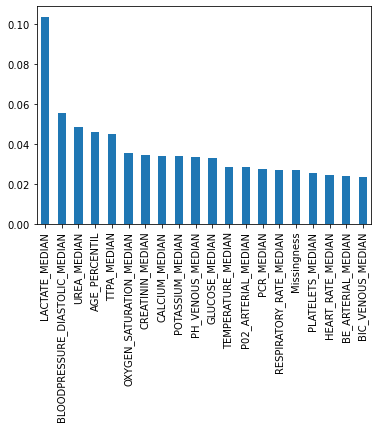

In [21]:
# Gini based feature importances
feat_importances = pd.Series(model.best_estimator_.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='bar')

In [22]:
# 11: Evaluation
def ass(y_true,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy=(tp+tn)/(tp+fp+fn+tn)
    precision = tp/(tp+fp)
    recall=tp/(tp+fn)

    #print("Recall:",recall*100)
    #print("Precision:",precision*100)
    #print("Accuracy:",accuracy*100)
    #print("F1 Score:", f1_score(y_true, y_pred)*100)
    #print("Precision-recall AUC:", auc(rf_recall, rf_precision))
    
    tab = [["Accuracy", accuracy*100], ["Recall", recall*100], ["Precision", precision*100], ["F1 Score", f1_score(y_true, y_pred)*100], ["Precision-recall AUC", auc(rf_recall, rf_precision)]]
    print(tabulate(tab, tablefmt="latex", headers = ['Evaluation Metric', 'Value']))
    

y_pred = model.predict(X_test)
# predict probabilities
rf_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
ass(y_test, model.predict(X_test))
print(confusion_matrix(y_test, y_pred))
    
#SimpleImputer
#Recall: 69.38775510204081
#Precision: 79.06976744186046
#Accuracy: 77.35849056603774
#F1 Score: 73.91304347826086
#ROC_AUC_Score: 76.79914070891513
#[[48  9]
 #[15 34]]

\begin{tabular}{lr}
\hline
 Evaluation Metric    &     Value \\
\hline
 Accuracy             & 73.5849   \\
 Recall               & 75.5102   \\
 Precision            & 69.8113   \\
 F1 Score             & 72.549    \\
 Precision-recall AUC &  0.736917 \\
\hline
\end{tabular}
[[41 16]
 [12 37]]


In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.72      0.75        57
           1       0.70      0.76      0.73        49

    accuracy                           0.74       106
   macro avg       0.74      0.74      0.74       106
weighted avg       0.74      0.74      0.74       106



Random Forest: f1=0.725 auc=0.737


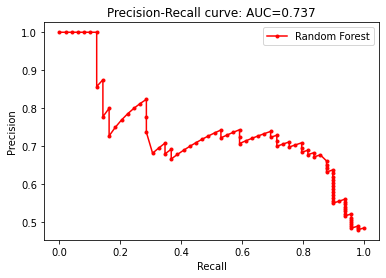

In [24]:
#PR AUC plot

rf_f1, rf_auc = f1_score(y_test, y_pred), auc(rf_recall, rf_precision)
# summarize scores
print('Random Forest: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))
# plot the precision-recall curves
plt.plot(rf_recall, rf_precision, marker='.', label='Random Forest', c = 'r')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# Title
plt.title('Precision-Recall curve: ''AUC={0:0.3f}'.format(auc(rf_recall, rf_precision)), loc='center')
# show the legend
plt.legend()
# show the plot
plt.show()



# SHAP

In [25]:
# 12: SHAP 
import shap
#final_model_pre = model.best_estimator_[1]
#final_model = final_model_pre.fit(X_train, y_train)
#model.best_estimator_[1]
check_additivity=False
explainer = shap.TreeExplainer(model.best_estimator_)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [26]:
shap_values = explainer.shap_values(X_train, check_additivity=False)

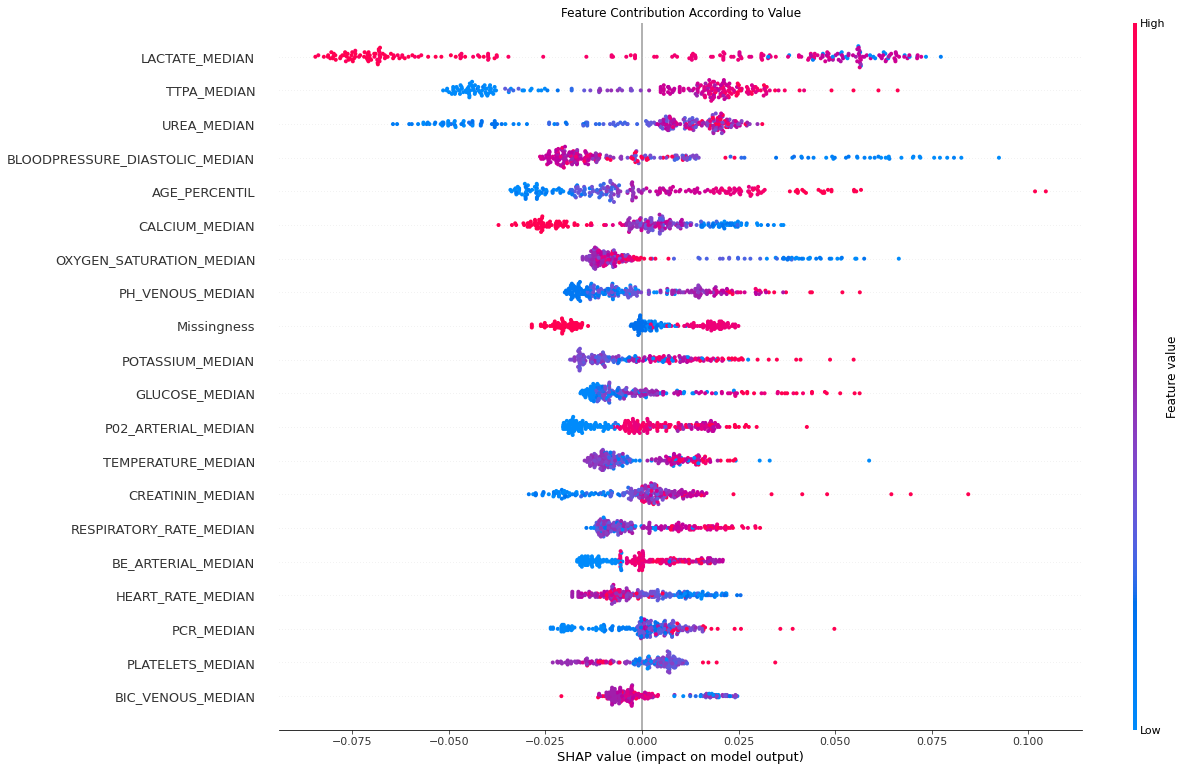

In [27]:
# Granular feature contribution plot
plt.title('Feature Contribution According to Value')
shap.summary_plot(shap_values[1], X_train, plot_size = (18,13))